<a href="https://colab.research.google.com/github/baicheto/AML_Bitcoin/blob/Kri/AML_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GraphSAGE

## Build the PyG Data object on G_int_full

In [ ]:
pyg_data = from_networkx(G_int_sub)
pyg_data.x = feat_intr.clone()

X_sub_gs = pyg_data.x.cpu().numpy()

In [ ]:
num_nodes_gs = y.size(0)
train_mask_gs = torch.zeros(num_nodes_gs, dtype=torch.bool)
val_mask_gs   = torch.zeros(num_nodes_gs, dtype=torch.bool)
test_mask_gs  = torch.zeros(num_nodes_gs, dtype=torch.bool)

mask_known_gs = (y >= 0)

ts_gs = ts_tensor.clone()

train_mask_gs[mask_known_gs & (ts_gs <= 30)]                 = True
val_mask_gs[  mask_known_gs & ((ts_gs >= 31) & (ts_gs <= 40)) ] = True
test_mask_gs[ mask_known_gs & (ts_gs >= 41) ]                 = True

In [ ]:
pyg_data.train_mask = train_mask_gs
pyg_data.val_mask   = val_mask_gs
pyg_data.test_mask  = test_mask_gs

In [ ]:
X_sub_gs = pyg_data.x.cpu().numpy()
train_mask_np = pyg_data.train_mask.cpu().numpy()

scaler = StandardScaler()
scaler.fit(X_sub_gs[train_mask_np])
X_scaled = scaler.transform(X_sub_gs)

In [ ]:
pyg_data.x = torch.tensor(X_scaled, dtype=torch.float, device=device)
pyg_data.y = y.clone().to(device)

pyg_data.train_mask = pyg_data.train_mask.to(device)
pyg_data.val_mask   = pyg_data.val_mask.to(device)
pyg_data.test_mask  = pyg_data.test_mask.to(device)

pyg_data = pyg_data.to(device)

## GraphSAGE Model

In [ ]:
class TwoLayerSAGE(nn.Module):
    def __init__(self, in_ch, hid_ch, out_ch, dropout=0.35):
        super().__init__()
        self.conv1 = SAGEConv(in_ch, hid_ch, aggr='mean')
        self.conv2 = SAGEConv(hid_ch, hid_ch, aggr='mean')
        self.lin   = nn.Linear(hid_ch, out_ch)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu( self.conv1(x, edge_index) )
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu( self.conv2(x, edge_index) )
        x = F.dropout(x, p=self.dropout, training=self.training)
        return self.lin(x)

In [ ]:
model = TwoLayerSAGE(
    in_ch    = pyg_data.x.size(1),
    hid_ch  = 48,
    out_ch    = 2,
    dropout        = 0.35
).to(device)

## Data Loaders

In [ ]:
train_loader = NeighborLoader(
    pyg_data,
    input_nodes   = pyg_data.train_mask,
    num_neighbors = [2],
    batch_size    = 512,
    shuffle       = True
)
val_loader = NeighborLoader(
    pyg_data,
    input_nodes   = pyg_data.val_mask,
    num_neighbors = [2],
    batch_size    = 512,
    shuffle       = False
)
test_loader = NeighborLoader(
    pyg_data,
    input_nodes   = pyg_data.test_mask,
    num_neighbors = [2],
    batch_size    = 512,
    shuffle       = False
)

## Training Setup

In [ ]:
optimizer = optim.Adam(
    model.parameters(),
    lr          = 0.0248,
    weight_decay= 1e-4
)
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_one_epoch():
    model.train()
    total_loss = 0.0
    total_samples = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        logits = out[:batch.batch_size]
        labels_batch = batch.y[:batch.batch_size]
        loss = criterion(logits, labels_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.batch_size
        total_samples += batch.batch_size
    return total_loss / total_samples

In [ ]:
@torch.no_grad()
def evaluate_split(loader):
    model.eval()
    all_true = []
    all_probs = []
    for batch in loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index)
        logits = out[:batch.batch_size]
        probs = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
        y_true = batch.y[:batch.batch_size].cpu().numpy()
        all_true.append(y_true)
        all_probs.append(probs)
    y_true = np.concatenate(all_true, axis=0)
    y_prob = np.concatenate(all_probs, axis=0)
    return y_true, y_prob

In [ ]:
max_epochs    = 498
patience      = 80
best_val_pr   = -1.0
best_state    = None
patience_ctr  = 0

val_pr_history = []

for epoch in range(1, max_epochs + 1):
    loss = train_one_epoch()

    y_val_true, y_val_prob = evaluate_split(val_loader)
    val_pr = average_precision_score(y_val_true, y_val_prob)
    val_roc = roc_auc_score(y_val_true, y_val_prob)

    val_pr_history.append(val_pr)
    print(f"Epoch {epoch:03d}  Loss: {loss:.4f}  Val PR: {val_pr:.4f}  Val ROC: {val_roc:.4f}")

    if val_pr > best_val_pr:
        best_val_pr = val_pr
        patience_ctr = 0
        torch.save(model.state_dict(), "sage_best.pt")
    else:
        patience_ctr += 1
        if patience_ctr >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch} "
                  f"(no val PR improvement for {patience} epochs).")
            print(f"Best Val PR was {best_val_pr:.4f}. Restoring those weights.\n")
            break

model.load_state_dict(torch.load("sage_best.pt"))

Epoch 001  Loss: 0.1767  Val PR: 0.8092  Val ROC: 0.9375
Epoch 002  Loss: 0.1673  Val PR: 0.8015  Val ROC: 0.9429
Epoch 003  Loss: 0.2219  Val PR: 0.7626  Val ROC: 0.9385
Epoch 004  Loss: 0.2074  Val PR: 0.8159  Val ROC: 0.9481
Epoch 005  Loss: 0.1506  Val PR: 0.7943  Val ROC: 0.9474
Epoch 006  Loss: 0.1593  Val PR: 0.8099  Val ROC: 0.9437
Epoch 007  Loss: 0.1817  Val PR: 0.8019  Val ROC: 0.9456
Epoch 008  Loss: 0.1587  Val PR: 0.7931  Val ROC: 0.9447
Epoch 009  Loss: 0.1521  Val PR: 0.7774  Val ROC: 0.9424
Epoch 010  Loss: 0.2448  Val PR: 0.6678  Val ROC: 0.9174
Epoch 011  Loss: 0.2026  Val PR: 0.7803  Val ROC: 0.9461
Epoch 012  Loss: 0.1764  Val PR: 0.7871  Val ROC: 0.9382
Epoch 013  Loss: 0.1864  Val PR: 0.7846  Val ROC: 0.9388
Epoch 014  Loss: 0.1771  Val PR: 0.7753  Val ROC: 0.9410
Epoch 015  Loss: 0.1682  Val PR: 0.7990  Val ROC: 0.9491
Epoch 016  Loss: 0.1610  Val PR: 0.8287  Val ROC: 0.9504
Epoch 017  Loss: 0.1653  Val PR: 0.8213  Val ROC: 0.9489
Epoch 018  Loss: 0.1601  Val PR

<All keys matched successfully>

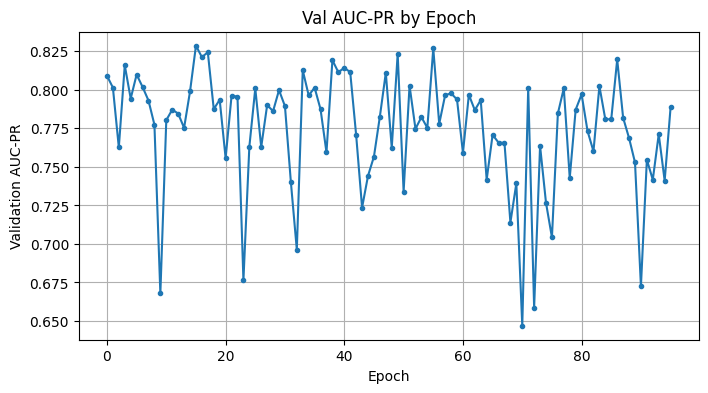

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(val_pr_history, marker='o', markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Validation AUC-PR')
plt.title('Val AUC-PR by Epoch')
plt.grid(True)
plt.show()

## Final Test Evaluation

In [ ]:
model.eval()
with torch.no_grad():
    out_all = model(pyg_data.x, pyg_data.edge_index)
    probs_all = torch.softmax(out_all, dim=1)[:,1].cpu().numpy()
    labels_all = pyg_data.y.cpu().numpy()

In [ ]:
test_mask_np = pyg_data.test_mask.cpu().numpy()
y_test_true  = labels_all[test_mask_np]
y_test_prob  = probs_all[test_mask_np]

M_test = y_test_true.shape[0]

In [ ]:
train_mask_np = pyg_data.train_mask.cpu().numpy()
y_train_true  = labels_all[train_mask_np]
prevalence    = y_train_true.mean()

In [ ]:
cutoffs = {
    "Top 0.1%":        max(1, int(0.001 * M_test)),
    "Top 1%":          max(1, int(0.01  * M_test)),
    "Top 10%":         max(1, int(0.10  * M_test)),
    "Prevalence": max(1, int(prevalence * M_test))
}

In [ ]:
n_runs = 100
metrics = {
    "roc_auc":     [],
    "pr_auc":      [],
    **{f"{name}_P": [] for name in cutoffs},
    **{f"{name}_R": [] for name in cutoffs},
    **{f"{name}_F1": [] for name in cutoffs},
}

rng       = np.random.RandomState(42)
half_size = M_test // 2

In [ ]:
for _ in range(n_runs):
    idxs = rng.choice(M_test, size=half_size, replace=False)
    y_true_bs = y_test_true[idxs]
    y_prob_bs = y_test_prob[idxs]

    metrics["roc_auc"].append(roc_auc_score(y_true_bs, y_prob_bs))
    metrics["pr_auc"].append(average_precision_score(y_true_bs, y_prob_bs))

    sorted_idx = np.argsort(y_prob_bs)
    for name, k in cutoffs.items():
        topk = sorted_idx[-k:]
        y_pred_bs = np.zeros_like(y_prob_bs, dtype=int)
        y_pred_bs[topk] = 1

        metrics[f"{name}_P"].append(precision_score(y_true_bs, y_pred_bs, zero_division=0))
        metrics[f"{name}_R"].append(recall_score(y_true_bs, y_pred_bs, zero_division=0))
        metrics[f"{name}_F1"].append(f1_score(y_true_bs, y_pred_bs, zero_division=0))

In [ ]:
for run_i in range(n_runs):
    idxs = rng.choice(M_test, size=half_size, replace=False)
    y_true_bs = y_test_true[idxs]
    y_prob_bs = y_test_prob[idxs]

    k0p1  = max(1, int(0.001 * half_size))
    k1p   = max(1, int(0.01  * half_size))
    k10p  = max(1, int(0.10  * half_size))
    kprev = max(1, int(prevalence * half_size))

    metrics["roc_auc"].append(roc_auc_score(y_true_bs, y_prob_bs))
    metrics["pr_auc"].append(average_precision_score(y_true_bs, y_prob_bs))

    sorted_idx = np.argsort(y_prob_bs)

    sample_cutoffs = {
        "Top 0.1%":  k0p1,
        "Top 1%":    k1p,
        "Top 10%":   k10p,
        "Prevalence":kprev
    }

    for name in cutoffs.keys():
        k_sample = sample_cutoffs[name]
        topk = sorted_idx[-k_sample:]

        y_pred_bs = np.zeros_like(y_prob_bs, dtype=int)
        y_pred_bs[topk] = 1

        p = precision_score(y_true_bs, y_pred_bs, zero_division=0)
        r = recall_score(y_true_bs, y_pred_bs, zero_division=0)
        f = f1_score(y_true_bs, y_pred_bs, zero_division=0)
        metrics[f"{name}_P"].append(p)
        metrics[f"{name}_R"].append(r)
        metrics[f"{name}_F1"].append(f)

In [ ]:
def fmt(name):
    arr = np.array(metrics[name])
    return f"{arr.mean():.3f} ± {arr.std():.3f}"

print("\n=== GraphSAGE Test Results (n=100 bootstraps) ===")
print(f"AUC-ROC  : {fmt('roc_auc')}")
print(f"AUC-PR   : {fmt('pr_auc')}")
for name in cutoffs:
    print(f"{name:12} Precision: {fmt(name + '_P')}")
    print(f"{name:12} Recall   : {fmt(name + '_R')}")
    print(f"{name:12} F1-score : {fmt(name + '_F1')}")


=== GraphSAGE Test Results (n=100 bootstraps) ===
AUC-ROC  : 0.806 ± 0.011
AUC-PR   : 0.526 ± 0.022
Top 0.1%     Precision: 0.909 ± 0.101
Top 0.1%     Recall   : 0.023 ± 0.010
Top 0.1%     F1-score : 0.045 ± 0.019
Top 1%       Precision: 0.957 ± 0.029
Top 1%       Recall   : 0.269 ± 0.087
Top 1%       F1-score : 0.411 ± 0.104
Top 10%      Precision: 0.229 ± 0.065
Top 10%      Recall   : 0.592 ± 0.044
Top 10%      F1-score : 0.322 ± 0.062
Prevalence   Precision: 0.212 ± 0.059
Prevalence   Recall   : 0.605 ± 0.048
Prevalence   F1-score : 0.307 ± 0.059
